# Symmetrical components

*A tutorial on how to work with power system symmetrical components and phasors in Python.*

Electrical power systems are often composed of three phases, i.e.: three sinusoidal waves delayed by 1/3 of a cycle between each other. This allows for the a constant power delivery with alternating voltage and current, optimized material cost and smooth current to the load. Those three phases are designated A, B and C.

This article shows how to present and manage such signals in a jupyter notebook, and will present how a three phase unbalanced circuit is derived into three balanced components - symmetrical components - to facilitate analysis.

> Talk a bit more about the technical side of things, or at least refer another guide that's really focused on the technical aspects.

## Requirements

This note was made in a [jupyter](https://jupyter.org/) notebook in [VS Code](https://code.visualstudio.com/), but the program itself can be run in a simple python script (a `.py` file). Assuming you're on Windows with the Python launcher installed (comes with recent versions of Python). The [NumPy](https://pypi.org/project/numpy/), [matplotlib](https://pypi.org/project/matplotlib/) and [energy-tools](https://pypi.org/project/energy-tools/) packages have to be installed manually with (on Windows):

`py -m pip install numpy matplotlib energy_tools`

On Linux, it probably depends on the system, but on mine I have to run `python3 -m pip install ...` instead of the above.

## Balanced 3-phase signals

First, the more-than-popular [NumPy](https://numpy.org/) library is required, in addition to [Matplotlib](https://matplotlib.org/) for visualization:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll first set a few basic parameters to plot a basic balanced, 3-phase signal over a full cycle:

In [2]:
freq_hz = 60  # Frequency (Hz)
samples = 1000  # Number of samples (unitless)
current = 100   # RMS current (A)

This value, however, is the rms current (root mean square), which is the value of direct current (DC) that would dissipate the same heat through a resistor. To plot waveforms, the current (and later the voltage) must be multiplied by $\sqrt{2}$ to show the correct amplitude.

In [3]:
i_peak = current * 2**0.5  # Peak current (A)

`numpy.linspace` is really conventient to create time periods over the desired range, with the desired number of samples:

In [4]:
# Time domain
t = np.linspace(0, 1 / freq_hz, samples)

`numpy.sin` expects radians ($2\pi=360°$), so the frequency needs to be converted accordingly:

In [5]:
# Currents for phases A, B and C
Ia = i_peak * np.sin(2 * np.pi * freq_hz * t)
Ib = i_peak * np.sin(2 * np.pi * freq_hz * t + (2 * np.pi / 3))
Ic = i_peak * np.sin(2 * np.pi * freq_hz * t + (4 * np.pi / 3))

> To avoid undesired text output from matplotlib in jupyter notebooks, the code paragraph should end with `plt.show()`. Putting a semicolon ";" at the end of the last line generally works as well, but it didn't always work in my case, contrary to this solution. See [here](https://stackoverflow.com/questions/45516770/how-do-i-omit-matplotlib-printed-output-in-python-jupyter-notebook) for more details.

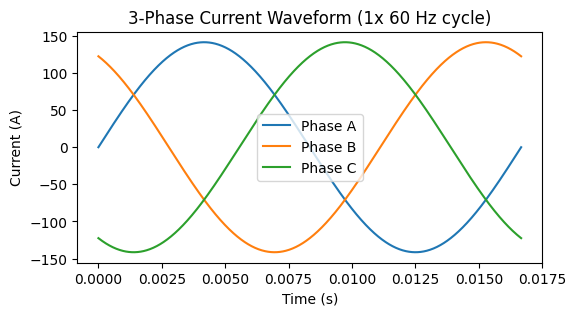

In [6]:
plt.figure(figsize=(6, 3))

plt.plot(t, Ia, label="Phase A")
plt.plot(t, Ib, label="Phase B")
plt.plot(t, Ic, label="Phase C")

plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title(f"3-Phase Current Waveform (1x {freq_hz} Hz cycle)")
plt.legend()

plt.show()

As I mentioned above, this allows us to transfer *constant power* with alternative current. For a 3-phase circuit, the power equals:

Where:
* S = Power (VA)
* V = Phase-to-phase voltage (V)
* I = Current (A)

> I'm intentionnal ignoring the nuance between apparent, reactive and active/real power for now; it's not required for this example.

We can thus calulate the power in the circuit assuming a phase-to-phase voltage. Using 280V - a common voltage in industrial distribution - the power is:

In [7]:
voltage = 208  # Volts (phase-to-phase)

The phase-to-phase voltage (rms) has to be converted to phase-to-ground (peak), by multiplying it by the square root or 2 and dividing it by the square root of 3:

In [8]:
vln_peak = voltage * 2**0.5 / 3**0.5

In [9]:
# Voltages for phases A, B and C
Va = vln_peak * np.sin(2 * np.pi * freq_hz * t)
Vb = vln_peak * np.sin(2 * np.pi * freq_hz * t + (2 * np.pi / 3))
Vc = vln_peak * np.sin(2 * np.pi * freq_hz * t + (4 * np.pi / 3))

Finally, the power is 

In [10]:
# Power for phases A, B and C (kVA)
Sa = Va * Ia / 1e3
Sb = Vb * Ib / 1e3
Sc = Vc * Ic / 1e3

Plotting for a single phase shows how the power is *not* constant. On a motor, this means vibration and it's not desirable.

> I like to clear the figure - using `plt.clf()` - between each plot to ensure I'm not carrying undesired settings from one figure to the next. The problem is that a semicolon at the end isn't enough to supress its annoying output, so `%%capture` is used instead.

In [11]:
%%capture
plt.clf()

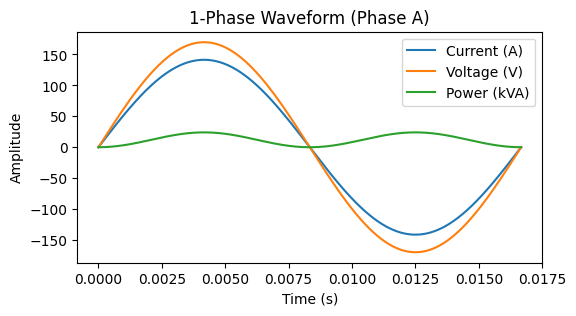

In [12]:
plt.figure(figsize=(6, 3))

plt.plot(t, Ia, label="Current (A)")
plt.plot(t, Va, label="Voltage (V)")
plt.plot(t, Sa, label="Power (kVA)")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"1-Phase Waveform (Phase A)")
plt.legend()

plt.show()

With the three phases, the total power output is clearly constant and equals:

In [13]:
%%capture
plt.clf()

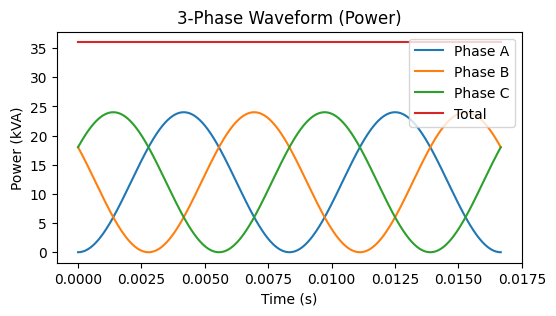

In [14]:
plt.figure(figsize=(6, 3))

plt.plot(t, Sa, label="Phase A")
plt.plot(t, Sb, label="Phase B")
plt.plot(t, Sc, label="Phase C")
plt.plot(t, Sa + Sb + Sc, label="Total")

plt.xlabel("Time (s)")
plt.ylabel("Power (kVA)")
plt.title(f"3-Phase Waveform (Power)")
plt.legend()

plt.show()

## Phasors

Electrical voltage, current and power are also often presented as phasors, which are basically vectors presented on a polar plot. The angle on the plot represents the phase, and the length of the vector the amplitude.

I made a small library, [energy-tools](https://gitlab.com/miek770/energy_tools) which includes a `Phasor` class that makes it easier to work with those, as well as an `EleComplex` class which improves the built in `Complex` type for electrical systems. The `Phasor` takes 2 arguments: the amplitude and the phase shift in degrees (optional, defaults to 0).

In [15]:
from energy_tools.phasor import Phasor

`a` is a convenient tool that simply allows us to shift another phasor by 120 degrees (or 240 degrees if `a` is quared): 

In [16]:
a = Phasor(1, 120)

We'll work with RMS amplitudes for the phasors. Because the currents are balanced in this example, we simply need to shift phase A by 120 degrees and 240 degrees to obtain phases B and C:

In [17]:
Ia = Phasor(current)
Ib = Ia * a
Ic = Ia * a**2

In [18]:
%%capture
plt.clf()

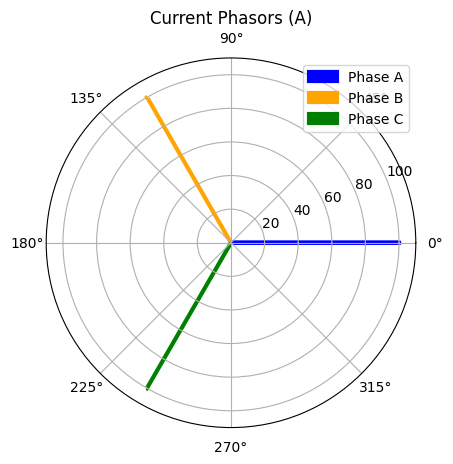

In [19]:
ax = plt.subplot(1, 1, 1, polar=True)

plt.arrow(0, 0, Ia.pha * np.pi / 180, Ia.amp, lw=3, color="blue", label="Phase A")
plt.arrow(0, 0, Ib.pha * np.pi / 180, Ib.amp, lw=3, color="orange", label="Phase B")
plt.arrow(0, 0, Ic.pha * np.pi / 180, Ic.amp, lw=3, color="green", label="Phase C")

plt.title("Current Phasors (A)")
ax.set_rlim(0, Ia.amp * 1.1)
plt.legend()

plt.show()

## Unbalanced 3-phase signals

In [20]:
# Function to generate unbalanced three-phase current waveform
def three_phase_current(amplitude, imbalance, samples, freq_hz):
    t = np.linspace(0, 1 / freq_hz, samples)
    Ia = amplitude * np.sin(2 * np.pi * freq_hz * t)
    Ib = amplitude * np.sin(2 * np.pi * freq_hz * t + (2 * np.pi / 3))
    Ic = amplitude * (1 + imbalance) * np.sin(2 * np.pi * freq_hz * t + (4 * np.pi / 3))
    return Ia, Ib, Ic

In [21]:
# Generate unbalanced three-phase current waveform
freq_hz = 60  # Hz
samples = 1000
amplitude = 100
imbalance = 0.2

In [22]:
Ia, Ib, Ic = three_phase_current(amplitude, imbalance, samples, freq_hz)

In [23]:
# Calculate symmetrical components at time=0
Ipos = (1 / 3) * (Ia[0] + Ib[0] + Ic[0])
Ineg = (1 / 3) * (Ia[0] + np.exp(2j * np.pi / 3) * Ib[0] + np.exp(-2j * np.pi / 3) * Ic[0])
Izero = (1 / 3) * (Ia[0] + Ib[0] + Ic[0]) - Ipos

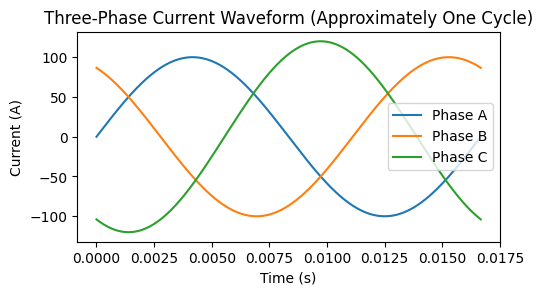

In [24]:
# Plot the time-domain waveform (approximately one cycle)
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
t = np.linspace(0, 1 / freq_hz, samples)
plt.plot(t, Ia, label='Phase A')
plt.plot(t, Ib, label='Phase B')
plt.plot(t, Ic, label='Phase C')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Three-Phase Current Waveform (Approximately One Cycle)')
plt.legend()

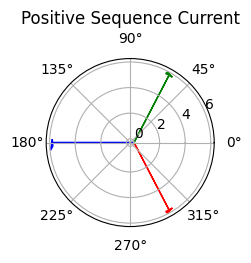

In [25]:
# Plot the positive sequence current phasors on a polar plot
plt.subplot(2, 2, 2, polar=True)
plt.title('Positive Sequence Current')
plt.arrow(0, 0, np.angle(Ipos), np.abs(Ipos), head_width=0.1, head_length=0.2, fc='b', ec='b')
plt.arrow(0, 0, np.angle(Ipos * np.exp(2j * np.pi / 3)), np.abs(Ipos), head_width=0.1, head_length=0.2, fc='r', ec='r')
plt.arrow(0, 0, np.angle(Ipos * np.exp(-2j * np.pi / 3)), np.abs(Ipos), head_width=0.1, head_length=0.2, fc='g', ec='g')

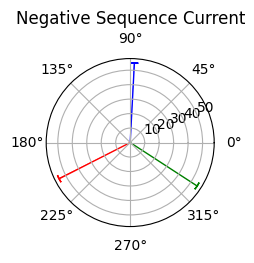

In [26]:
# Plot the negative sequence current phasors on a polar plot
plt.subplot(2, 2, 3, polar=True)
plt.title('Negative Sequence Current')
plt.arrow(0, 0, np.angle(Ineg), np.abs(Ineg), head_width=0.1, head_length=0.2, fc='b', ec='b')
plt.arrow(0, 0, np.angle(Ineg * np.exp(2j * np.pi / 3)), np.abs(Ineg), head_width=0.1, head_length=0.2, fc='r', ec='r')
plt.arrow(0, 0, np.angle(Ineg * np.exp(-2j * np.pi / 3)), np.abs(Ineg), head_width=0.1, head_length=0.2, fc='g', ec='g')

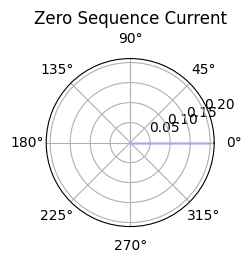

In [27]:
# Plot the zero sequence current phasor on a polar plot
plt.subplot(2, 2, 4, polar=True)
plt.title('Zero Sequence Current')
plt.arrow(0, 0, np.angle(Izero), np.abs(Izero), head_width=0.1, head_length=0.2, fc='b', ec='b')

In [28]:
# Adjust the layout
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [29]:
# Save the figure as a PNG image
plt.savefig('current_waveform.png')
plt.show()

<Figure size 640x480 with 0 Axes>